In [1]:
import numpy as np
from MultiplexDiff import MultiplexDiffusion
import networkx as nx

In [2]:
import numpy as np
from MultiplexDiff import MultiplexDiffusion
import networkx as nx
import matplotlib.pyplot as plt

def get_activation_times(diffusion_sequence, num_nodes):
    """
    Given a diffusion sequence (list of sets of activated nodes), 
    return an array where the i-th element is the time step at which node i was activated.
    If a node is never activated, assign it a value equal to len(diffusion_sequence).
    """
    activation_times = np.full(num_nodes, fill_value=len(diffusion_sequence), dtype=float)
    for t, activated in enumerate(diffusion_sequence):
        for node in activated:
            if activation_times[node] == len(diffusion_sequence):
                activation_times[node] = t
    return activation_times

def predict_second_layer(A1, training_diffusion_sequences, threshold=1):
    """
    Predicts the second layer's adjacency matrix and edge probability (p) from the known first layer (A1)
    and the training set of diffusion sequences.
    
    For each pair of nodes (i, j) not connected in A1, we count how many training runs show that one node
    activates exactly one time step before the other. If the count meets or exceeds the threshold,
    we predict an edge between i and j in the second layer.
    
    Parameters:
        A1 (np.array): Adjacency matrix of the first layer.
        training_diffusion_sequences (list): List of diffusion sequences (each a list of sets).
        threshold (int): Minimum count of “immediate activation” events required to predict an edge.
    
    Returns:
        A2_pred (np.array): Predicted adjacency matrix for the second layer.
        p_pred (float): Predicted edge probability (density) for the second layer.
    """
    n = A1.shape[0]
    # Compute activation times for each training run.
    activation_times_list = []
    for seq in training_diffusion_sequences:
        act_times = get_activation_times(seq, n)
        activation_times_list.append(act_times)
    
    # Initialize a score matrix.
    score_matrix = np.zeros((n, n))
    
    # For each training run, check for each unordered pair (i, j)
    # whether one node activated immediately (one step) before the other.
    for act_times in activation_times_list:
        for i in range(n):
            for j in range(i + 1, n):
                if act_times[i] + 1 == act_times[j]:
                    score_matrix[i, j] += 1
                    score_matrix[j, i] += 1  # Undirected graph
    
    # Predict A2 for pairs that are not in A1 (ignoring self-loops).
    A2_pred = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            if A1[i, j] == 0 and score_matrix[i, j] >= threshold:
                A2_pred[i, j] = 1
                A2_pred[j, i] = 1
                
    # Calculate predicted p as the density (fraction of possible edges present).
    num_possible_edges = n * (n - 1) / 2
    num_edges_pred = np.sum(A2_pred) / 2  # Since the matrix is symmetric.
    p_pred = num_edges_pred / num_possible_edges
    return A2_pred, p_pred

def jaccard_similarity(A_true, A_pred):
    """
    Computes the Jaccard similarity between two adjacency matrices,
    treating the set of edges (upper triangular, excluding the diagonal) as sets.
    """
    n = A_true.shape[0]
    true_edges = set()
    pred_edges = set()
    for i in range(n):
        for j in range(i + 1, n):
            if A_true[i, j] > 0:
                true_edges.add((i, j))
            if A_pred[i, j] > 0:
                pred_edges.add((i, j))
    if not true_edges and not pred_edges:
        return 1.0
    intersection = len(true_edges.intersection(pred_edges))
    union = len(true_edges.union(pred_edges))
    return intersection / union if union > 0 else 0

def plot_networks_side_by_side(A_pred, A_true, p_pred, true_p,
                               title_pred="Predicted Layer 2", title_true="Actual Layer 2"):
    """
    Plots the predicted and actual networks side by side.
    
    Parameters:
        A_pred (np.array): Predicted adjacency matrix for layer 2.
        A_true (np.array): Actual adjacency matrix for layer 2.
        p_pred (float): Predicted edge probability.
        true_p (float): True edge probability (from the network generation parameter).
        title_pred (str): Title for the predicted network plot.
        title_true (str): Title for the actual network plot.
    """
    G_pred = nx.from_numpy_array(A_pred)
    G_true = nx.from_numpy_array(A_true)
    
    # Use a consistent layout for both graphs.
    pos = nx.spring_layout(G_true, seed=42)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot predicted network.
    nx.draw_networkx(G_pred, pos=pos, ax=axes[0], with_labels=True)
    axes[0].set_title(f"{title_pred}\np={p_pred:.3f}")
    
    # Plot actual network.
    nx.draw_networkx(G_true, pos=pos, ax=axes[1], with_labels=True)
    axes[1].set_title(f"{title_true}\np={true_p:.3f}")
    
    plt.tight_layout()
    plt.show()

In [17]:
num_nodes = 10
num_layers = 2
# Create a multiplex network with two layers:
# Layer 0: IC model with p=0.1, Layer 1: IC model with p=0.2.
layer_models = [("IC", 0.1), ("IC", 0.2)]
md = MultiplexDiffusion(num_nodes, num_layers)
md.create_network(layer_models)

# Extract adjacency matrices.
adj_matrices = md.get_adjacency_matrices()
A1 = adj_matrices[0]
A2_true = adj_matrices[1]
true_p2 = md.layers[1]["param"]

print("True edge probability for Layer 2:", true_p2)
print("Adjacency matrix of Layer 2:")
print(A2_true)

True edge probability for Layer 2: 0.2
Adjacency matrix of Layer 2:
[[0. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 1. 1.]
 [1. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 0.]
 [1. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1. 0. 0. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]]


Predicted adjacency matrix for second layer:
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]]
Predicted p for second layer: 0.178
True p for second layer: 0.200
Jaccard similarity between true and predicted second layer: 0.077


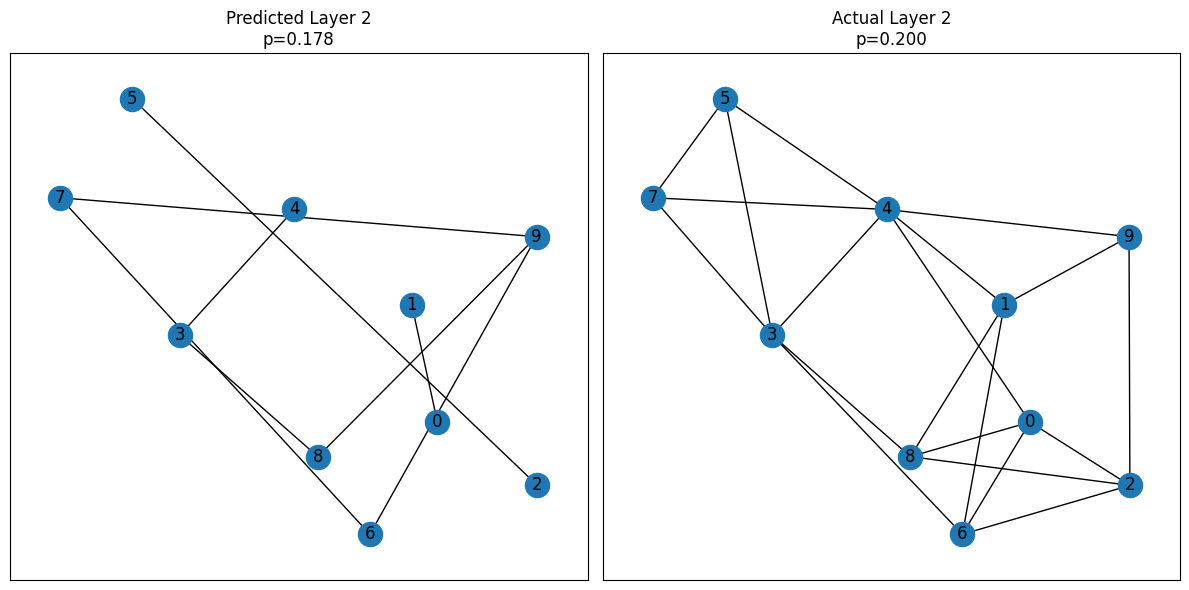

In [18]:
# Create a training set by running the diffusion process 5 times with 5 starting nodes.
training_diffusion_sequences = []
num_runs = 50000
k = 2
for _ in range(num_runs):
    seq = md.run_diffusion(k)
    training_diffusion_sequences.append(seq)

# Use the training set to predict the second layer.
A2_pred, p_pred = predict_second_layer(A1, training_diffusion_sequences, threshold=1)

print("Predicted adjacency matrix for second layer:")
print(A2_pred)
print(f"Predicted p for second layer: {p_pred:.3f}")
print(f"True p for second layer: {true_p2:.3f}")

# Calculate accuracy using the Jaccard similarity measure.
accuracy = jaccard_similarity(A2_true, A2_pred)
print(f"Jaccard similarity between true and predicted second layer: {accuracy:.3f}")

# Plot the predicted network and actual network side by side.
plot_networks_side_by_side(A2_pred, A2_true, p_pred, true_p2)
